In [10]:
import scipy
import sympy
from sympy import Function, Symbol, Derivative, diff, integrate, Piecewise
from sympy import sin, pi, sqrt, oo
from sympy.physics.quantum.constants import hbar
from sympy.physics.quantum.operator import DifferentialOperator, Operator
from sympy.physics.quantum.state import Wavefunction
from sympy.physics.quantum.qapply import qapply

import numpy as np
from matplotlib import pyplot as plt

In [93]:

# Define number of basis
nbasis = 30

# Construct the basis (eigenfuncitons)
x = Symbol('x')
n = Symbol('n')
m = Symbol('m')
ma = hbar**2/2.0
w = sympy.sqrt(1./2. / ma)
L = 20.0

g = Piecewise((0, x < 0), (0, x > L), (sqrt(2./L)*sin(n*pi*x/L), True))
# g = sqrt(2./L)*sin(n*pi*x/L)
phin = Wavefunction(g, x)
phim = phin.subs(n, m)

f = Function('f')
T = DifferentialOperator(-hbar**2/(2*ma) * Derivative(f(x), x, x), f(x))
V = 1./2. * ma * (w**2) * (x - L/2.)**2

In [94]:
H = T + V

In [95]:
H

25.0*(0.1*x - 1)**2 + DifferentialOperator(-1.0*Derivative(f(x), (x, 2)),f(x))

In [96]:
(phim.expr*(qapply(T * phin).expr)).simplify()

Piecewise((0, (x > 20.0) | (x < 0)), (0.00025*pi**2*n**2*sin(0.05*pi*m*x)*sin(0.05*pi*n*x), True))

In [97]:
hmn = (phim.expr*(V * phin.expr + qapply(T * phin).expr)).simplify()
# Exact expression of the integrand hmn, needing to be integrated from -oo to oo
hmn

Piecewise((0, (x > 20.0) | (x < 0)), ((0.00025*pi**2*n**2 + 2.5*(0.1*x - 1)**2)*sin(0.05*pi*m*x)*sin(0.05*pi*n*x), True))

In [98]:
from sympy import N
tmn = (phim.expr*(qapply(T * phin).expr)).simplify()
N(integrate(tmn.evalf(subs={m: 1, n: 5}), (x, -oo, oo)))

0

In [99]:
# Sanity check for h11
integrate(hmn.evalf(subs={m: 1, n: 1}), (x, 0, L))

8.35800734433605 - 50.0/pi**2

In [100]:
from tqdm.auto import tqdm
# Construct the Hamitonian matrix elements
# matrix_elements = []
Hmn = np.zeros((nbasis, nbasis))
for i in tqdm(range(1, nbasis+1)):
    row = []
    for j in range(1, nbasis+1):
        # Substitute m and n values into hmn and integrate
        element = integrate(hmn.evalf(subs={m: i, n: j}), (x, 0, L))
        Hmn[i-1, j-1] = N(element)
        row.append(element)
    # matrix_elements.append(row)


100%|█████████████████████████████████████████████████████| 30/30 [14:44<00:00, 29.47s/it]


In [101]:
# Trim out the contant basis function (n=0)
Hmn_ = Hmn#[1:,1:]

In [102]:
print(Hmn_.shape)

(30, 30)


In [103]:
import scipy.linalg as LA
from sympy import lambdify

# Solve eigenvalues and eigenvectors

eigvalues, eigvectors = LA.eigh(Hmn_)

phi_nx = lambdify((x, n), phin.expr, "numpy")

In [104]:
# Some sanity check for the coefficient of the first basis function
import math
math.sqrt(2/L)

0.31622776601683794

In [105]:
phin.expr

Piecewise((0, (x > 20.0) | (x < 0)), (0.316227766016838*sin(0.05*pi*n*x), True))

In [106]:
# Sort eigenvalues in ascending order
indices = np.argsort(eigvalues)
first = 7
print(eigvalues[indices[:first]])

[ 0.5         1.5         2.5         3.5         4.5         5.5
  6.5         7.5         8.5         9.5        10.50000015 11.50000018
 12.50000553 13.50000607 14.50012339 15.50012964 16.5017814  17.50185133
 18.51614034 19.51681431 20.59648889 21.6026999  22.88656785 23.91707561
 25.69909723 26.78987889 29.50037308 30.68284951 36.04350468 37.37013812]


In [114]:
import numpy as np

# Check orthonormality
cmn = eigvectors[:,indices].T @ eigvectors[:,indices]
print(cmn.diagonal())
print(cmn.diagonal(offset=1))
print(np.allclose(cmn.diagonal(offset=1), 0))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
[-1.85921785e-17 -1.61203857e-17  1.78868017e-17  4.94828326e-17
  2.75673531e-18  4.26773036e-17 -3.46842463e-17  4.13175049e-17
  4.34809909e-18  4.81152584e-17  2.83220038e-17 -5.99552206e-17
 -4.18051260e-17  5.47615519e-17  1.25036590e-16 -1.56943450e-16
  1.07845362e-16  1.12006619e-16 -1.72039596e-17 -5.99325402e-18
  1.49581897e-17 -2.20505371e-17 -3.92317967e-18 -3.60214549e-17
 -3.63805408e-18  2.19956805e-17 -6.00472059e-18  2.66583276e-18
  2.92802767e-19]
True


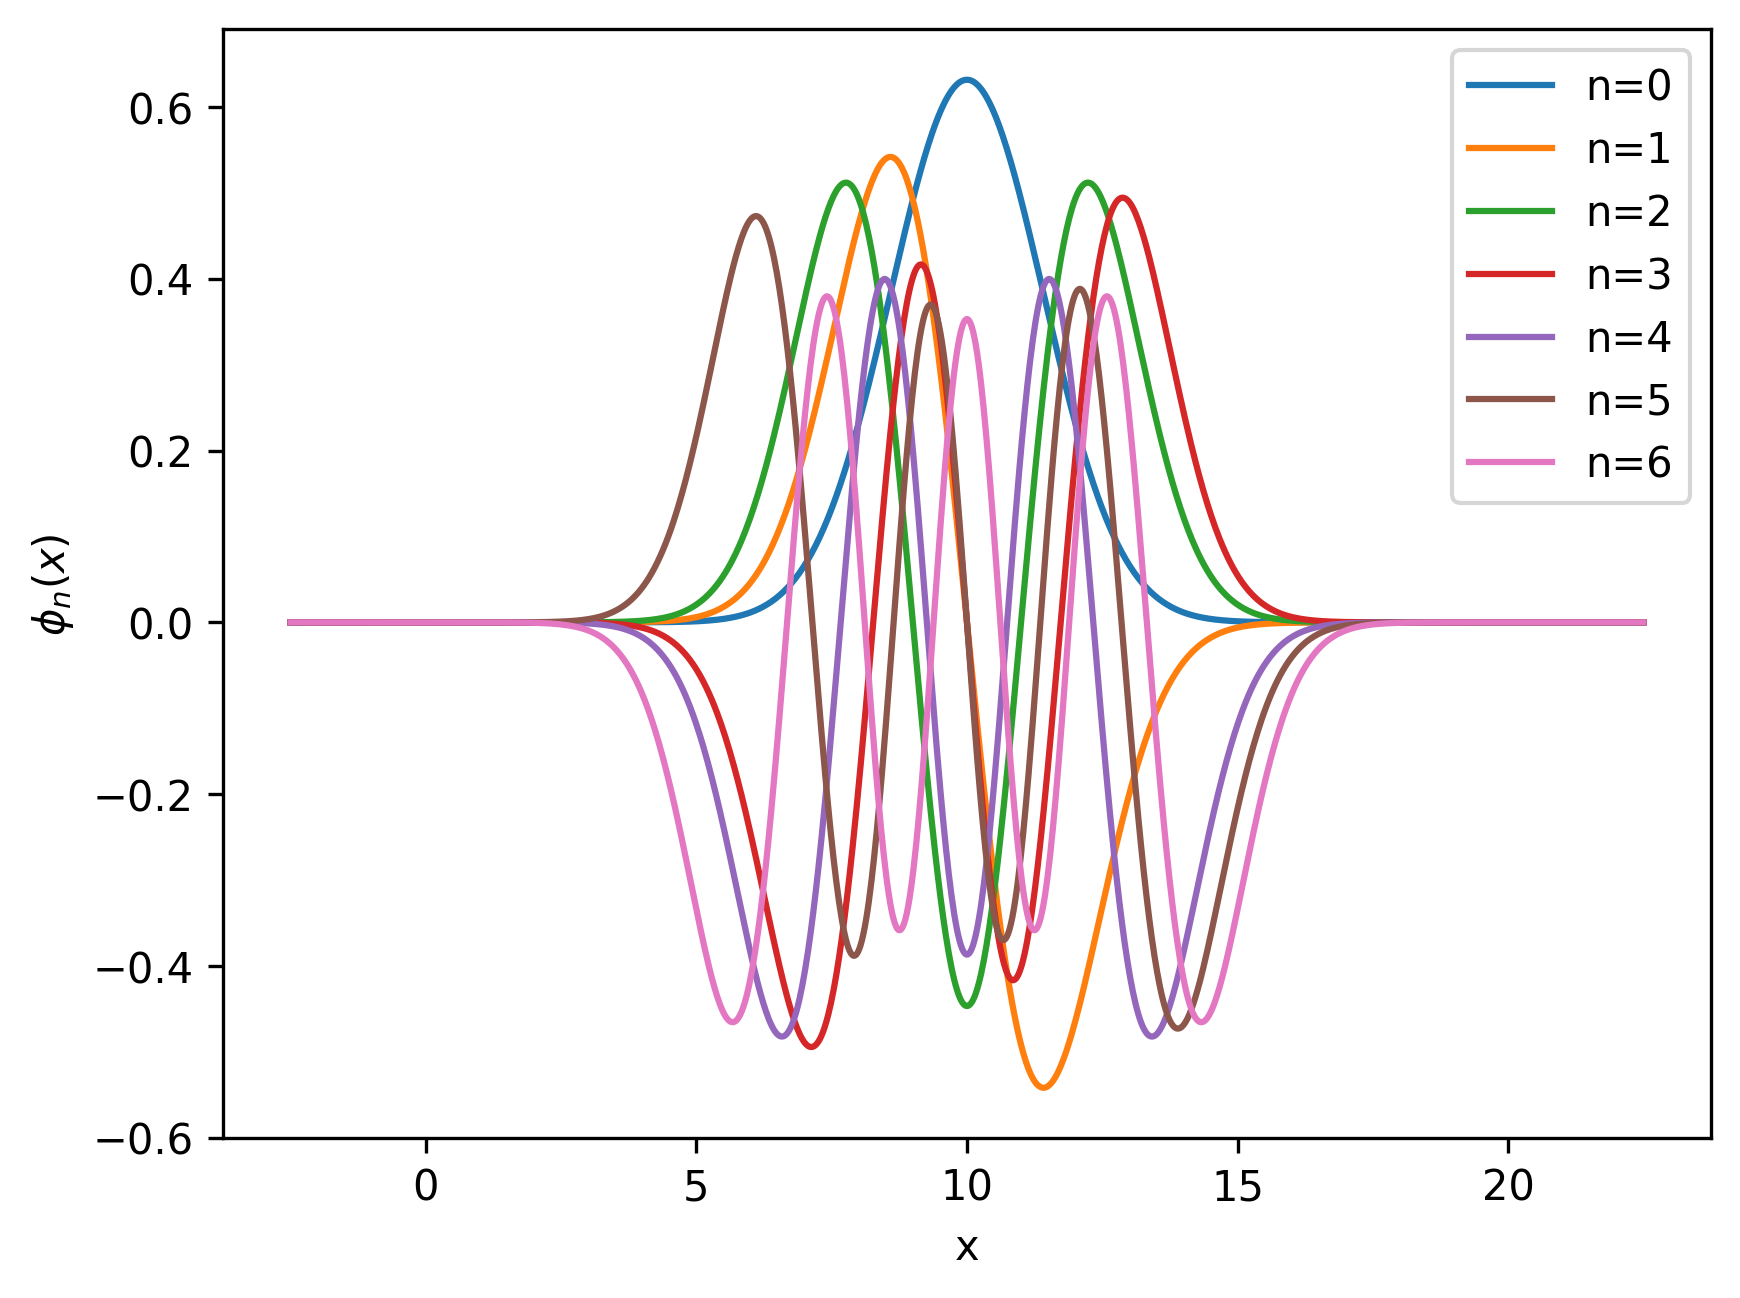

In [150]:
from matplotlib import pyplot as plt

xs = np.linspace(-0.125*L, 1.125*L, int(1e3))
phis_x = np.vstack(tuple(map(lambda j: phi_nx(xs, j+1), range(nbasis))))

with plt.style.context('default'):
    fig, ax = plt.subplots(dpi=300)
    
    for i, ys in enumerate(np.dot(eigvectors[:, indices[:first]].T, phis_x)):
        ax.plot(xs, ys, label=f'n={i}')
        
    ax.legend()
    ax.set(xlabel='x', ylabel='$\phi_n(x)$')
    plt.savefig('ho-sine-approx.png')
    plt.show()